In [ ]:
###Note it is nessasary to have the related .gwf filles (challenge1 & challenge2)

In [1]:
### Set 1: Challange 1

###load in useful tools
! pip install pycbc
! pip install -q 'gwpy==3.0.8'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 15.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 85.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 100.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 MB 77.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 16.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━

In [3]:
###Part 1: Load data into memmory
###load data onto memory/    pyCBC
from pycbc import frame
pycbc_strain1 = frame.read_frame('challenge1.gwf', 'H1:CHALLENGE1')

###load data onto memory/   gwpy
from gwpy.timeseries import TimeSeries
gwpy_strain1 = TimeSeries.read('challenge1.gwf', channel="H1:CHALLENGE1")


###Sample rate and legth of data
print("Sample Rate:",pycbc_strain1.get_sample_rate())
print("Duration:",pycbc_strain1.get_duration())

Sample Rate: 4096.0
Duration: 128.0


Text(0.5, 1.0, 'Data in Time-Domain')

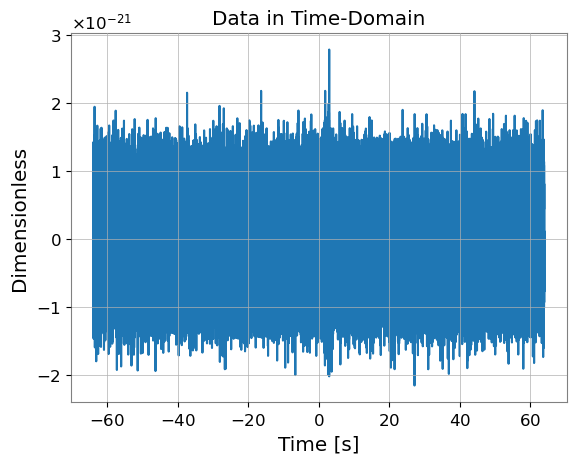

In [9]:
###Part 2: Ploting the data in the time domain
import matplotlib.pyplot as plt
plot = pycbc_strain1.plot()
plt.xlabel('Time [s]')
plt.ylabel('Dimensionless')
plt.title('Data in Time-Domain')

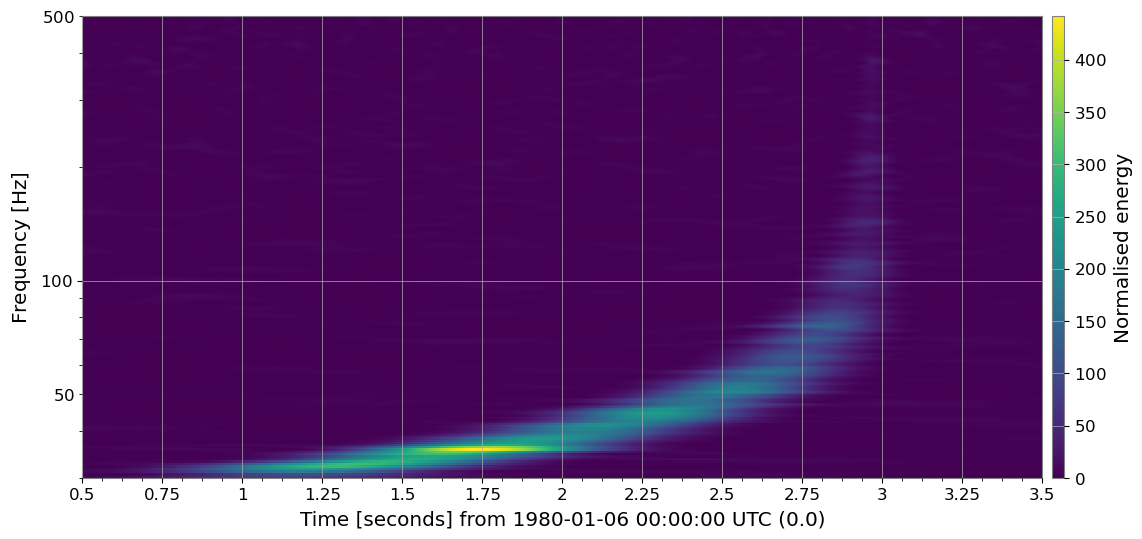

In [12]:
###Part 3: Q transform

Gwpy1_q1 = gwpy_strain1.q_transform(frange=(30, 500), qrange=(70, 110),outseg=(0.5,3.5))
plot = Gwpy1_q1.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

In [13]:
###Part 4: Time of the merger

print("The approximate time of the merger is 67 seconds into the recording")

The approximate time of the merger is 67 seconds into the recording


In [14]:
### Set 1: Challange 2
### Load data
pycbc_strain2 = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')
gwpy_strain2 = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")

The approximate time of the merger is about 59.4 seconds into the recording


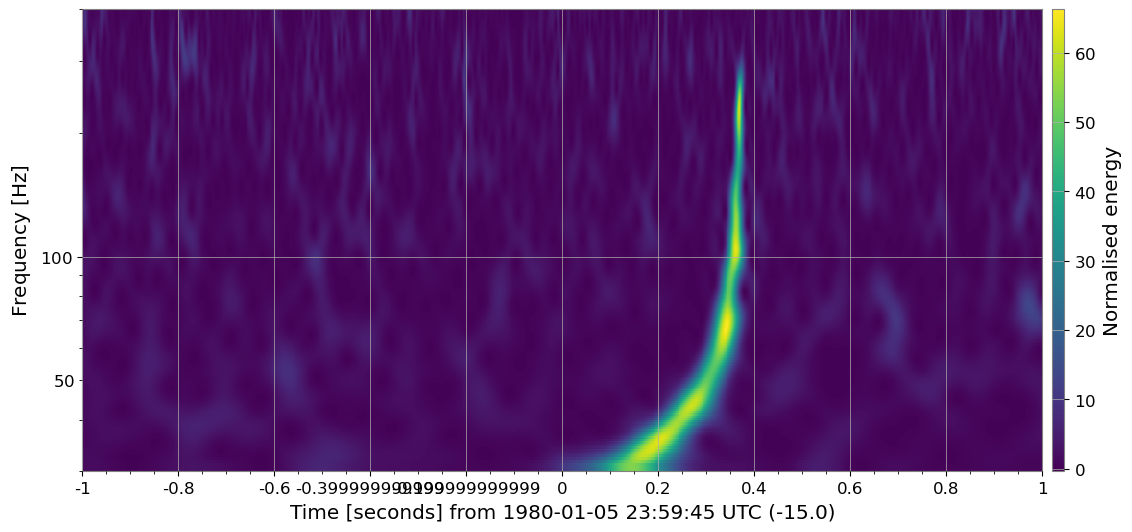

In [18]:
###Part 1: Estimate time of merger from a Q transform

Gwpy2_q1 = gwpy_strain2.q_transform(frange=(30, 400), qrange=(10, 110),outseg=(-16,-14))
plot = Gwpy2_q1.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

print("The approximate time of the merger is about 59.4 seconds into the recording")

In [25]:
###Part 2: Generate a time domain function

###Stuff for me
from pycbc.waveform import get_td_waveform
import pylab


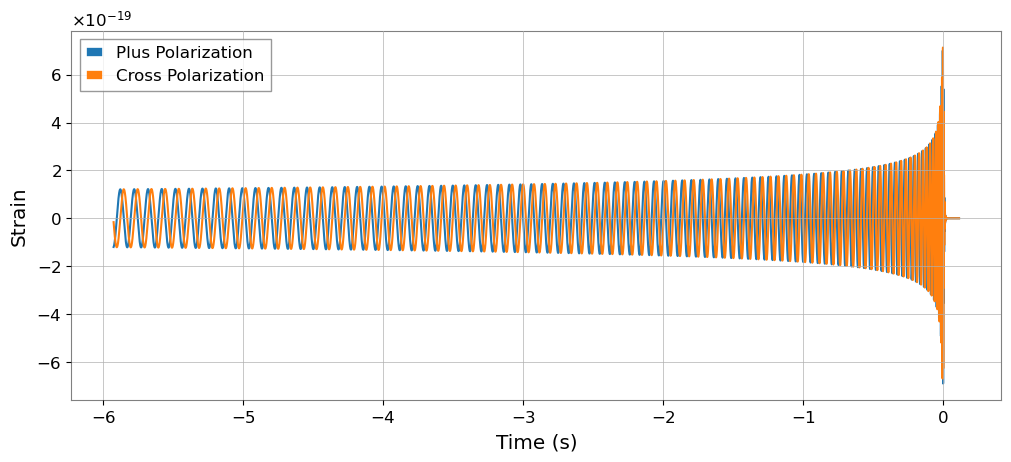

In [26]:
### ploting the wave
hplus, hcross = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         delta_t=1.0/sample_rate,
                         f_lower=10)

pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hplus.sample_times, hplus, label='Plus Polarization')
pylab.plot(hcross.sample_times, hcross, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()

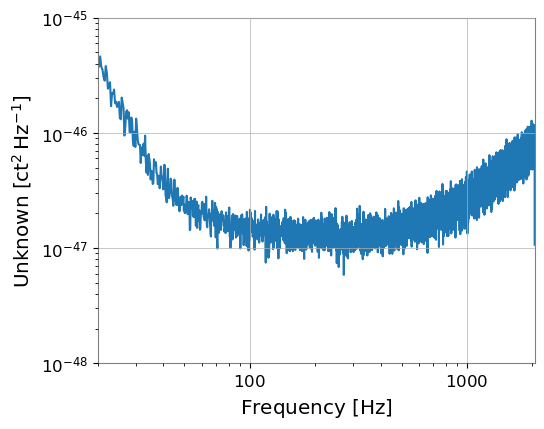

In [34]:
###Part 3: Calculate a PSD of the data

###nyquist frequency half total 
sample_rate = pycbc_strain2.get_sample_rate()
nyquist_f = sample_rate/2

### PSD plo
psd1 = gwpy_strain2.psd(fftlength=4, method="median")
plotpsd = psd1.plot()
ax = plotpsd.gca()
ax.set_xlim(20, nyquist_f)
ax.set_xscale("log")
ax.set_ylim(1e-48, 1e-45)
ax.set_yscale("log")

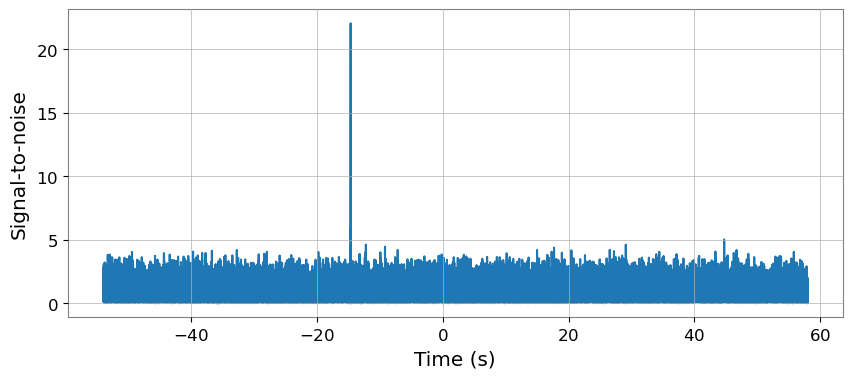

In [109]:
###Part 4: SNR time series

### Data Conditioning (i think) ## study this later
import pylab
from pycbc.filter import resample_to_delta_t, highpass

##Highpass???? Study this later
high = highpass(pycbc_strain2, 15.0)

conditioned1_pycbc = high.crop(2, 2)
len(conditioned1_pycbc)


##didn't work friends said stuff about data consistancy 
delta_t = 1.0/sample_rate
hplus, hcross = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=30,
                     mass2=30,
                     delta_t=conditioned1_pycbc.delta_t,
                     f_lower=20)

hplus.resize(len(conditioned1_pycbc)) ##should be the consistancy fix

template = hplus.cyclic_time_shift(hplus.start_time)

from pycbc.psd import interpolate, inverse_spectrum_truncation
psd = conditioned1_pycbc.psd(4)
psd = interpolate(psd, conditioned1_pycbc.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned1_pycbc.sample_rate),
                                  low_frequency_cutoff=15)

###Plotting the SNR time series
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned1_pycbc,
                     psd=psd, low_frequency_cutoff=20)


snr = snr.crop(4 + 4, 4)


pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

In [110]:
###Part 5: matched filter snr

print("Signal at {}s with SNR {}".format(time,abs(snrp)))   ## Study why this works later

Signal at -14.6328125s with SNR 22.05533521121293


Text(0, 0.5, 'strain')

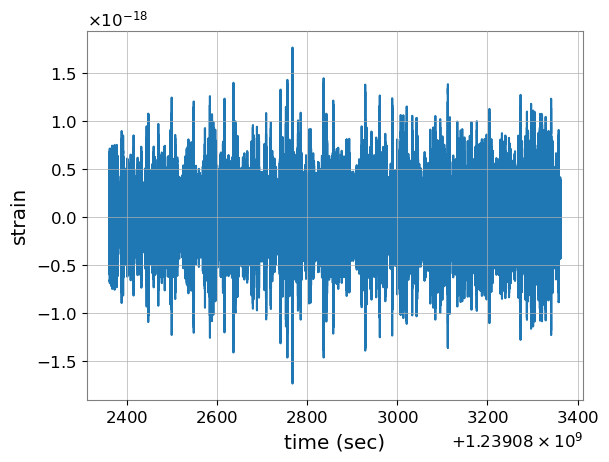

In [130]:
### Set 2: Detector Noise
### Note: download and upload noise_ts_4096Hz.npy
### Loading data
import numpy as np
import pycbc
from pycbc.types import FrequencySeries, TimeSeries
import matplotlib.pyplot as plt

d = np.load('noise_ts_4096Hz.npy')

time = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = time[1]-
time[0])
data = d

###plot as a test
plt.plot(time, data)
plt.xlabel('time (sec)')
plt.ylabel('strain')



(1e-47, 1e-40)

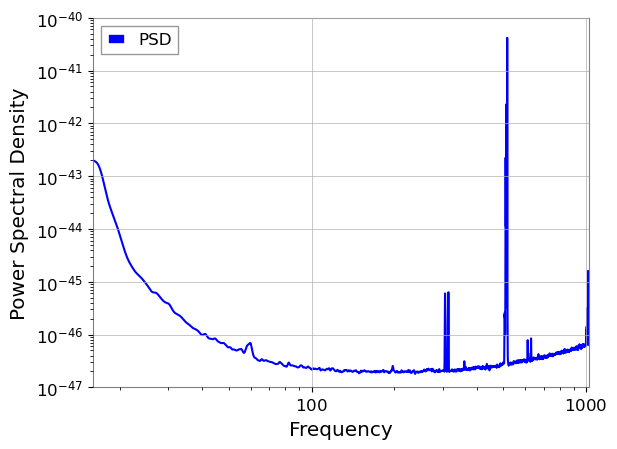

In [131]:
###Part 1

from pycbc.psd import welch, interpolate, inverse_spectrum_truncation
import pylab

#Frequancy domain
fre_data = data.to_frequencyseries()
plt.plot(time, data, color='blue') 
plt.xlabel('time (sec)')
plt.ylabel('strain')


###plotting the PSD
psdLigo = interpolate(data.psd(2), fre_data.delta_f)
psdLigo = inverse_spectrum_truncation(psdLigo, int(2*data.sample_rate), low_frequency_cutoff=15.0, trunc_method='hann')
pylab.loglog(psdLigo.sample_frequencies, psdLigo, label='PSD', color='blue') 
pylab.xlabel("Frequency")
pylab.ylabel("Power Spectral Density")
pylab.legend()
pylab.xlim(16, 1024)
pylab.ylim(1e-47, 1e-40)

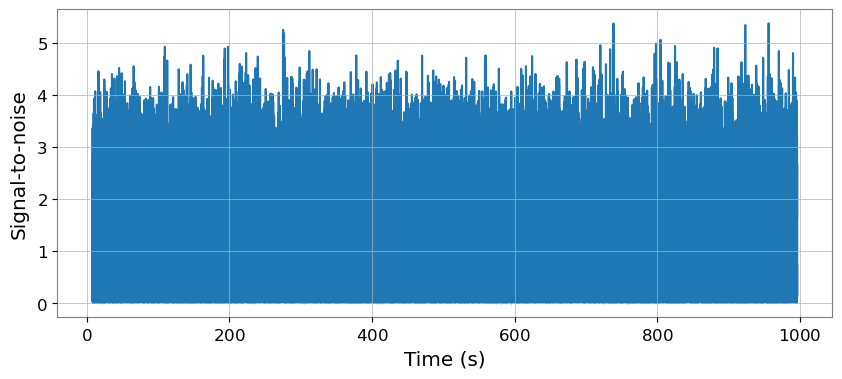

We found a signal at 956.027099609375s with SNR 5.372673849581942


In [132]:
###Checking for Gravitational wave 

from pycbc.psd import interpolate, inverse_spectrum_truncation
###Estimate PSD

psdLigo1_1 = data.psd(4)

###Interpolate PSD
psdLigo1_1 = interpolate(psdLigo1_1, data.delta_f)
psdLigo1_1 = inverse_spectrum_truncation(psdLigo1_1, int(4 * data.sample_rate),low_frequency_cutoff=15)


from pycbc.waveform import get_td_waveform



hplus, hcross = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=10,  ## 10 cause ite between 5 and 10 and 10 seems fun
                     mass2=10,
                     delta_t=data.delta_t,
                     f_lower=20)

### Resize
hplus.resize(len(data))

from pycbc.filter import matched_filter
import numpy
### Plot and Identify
snr = matched_filter(template, data,
                     psd=psdLigo1_1, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))


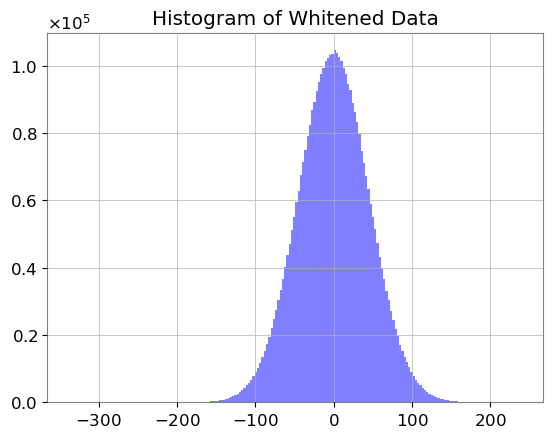

This is a gaussian distribution centered at 0


In [135]:
###Histogram of Whitened data   ## data whitened just like teeth lol

import pycbc.psd
### White data From psdLigo
white_data = (data.to_frequencyseries() / psdLigo**0.5).to_timeseries()
white_data=white_data.crop(5,5)
### Histogram
n, bins, patches = plt.hist(white_data, 200, facecolor='blue', alpha=0.5)
plt.title("Histogram of Whitened Data")
plt.show()


print("This is a gaussian distribution centered at 0")

Text(0, 0.5, 'Probability')

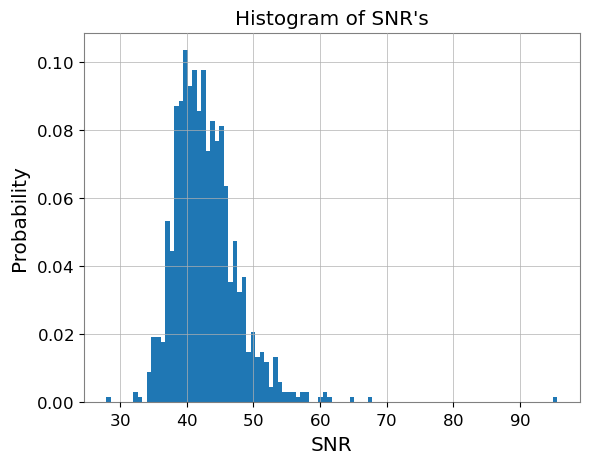

In [139]:
### Stationary test


###Generate Wave
from pycbc.waveform import get_fd_waveform
f_final = 2048.0

####Generate frequency domain
hplus, hccross = get_fd_waveform(approximant="TaylorF2", 
                          mass1=10, 
                          mass2=10, 
                          delta_f=1.0/200.0, 
                          distance=500,  
                          f_lower=20, 
                          f_final=2048)

### PSD
psdLast = pycbc.psd.interpolate(pycbc.psd.welch(data), hplus.delta_f)

### SNR
snr = np.sqrt(pycbc.filter.sigmasq(hplus, psdLast))

### data slicing
slices = 1000
data_slice_length = len(data) // slices

SNR_all = []
### Iteration from Data Slices
for i in range(slices):
    data_piece = data[i * data_slice_length: (i + 1) * data_slice_length]
    psdLast_piece = pycbc.psd.interpolate(pycbc.psd.welch(data_piece), hplus.delta_f)
    SNR_piece = np.sqrt(pycbc.filter.sigmasq(hplus, psdLast_piece))
    SNR_all.append(SNR_piece)

### HIstorgram
plt.hist(SNR_all, 100, density=True)
plt.title("Histogram of SNR's")
plt.xlabel("SNR")
plt.ylabel("Probability")



### Finaly done